<a href="https://colab.research.google.com/github/ZYtheNOOOB/iGPT-MNIST/blob/main/Transformer_MNIST_Generation.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Transformer Model for MNIST Image Generation

A transformer decoder model based on Image-GPT in hand written digits generation.

**Author: Jiaye Zhu, 05/05/2022**

Credits:

[Generative Pretraining from Pixels (OpenAI Paper)](https://cdn.openai.com/papers/Generative_Pretraining_from_Pixels_V2.pdf)

[GregorKobsik / ImageTransformer (Github)](https://github.com/GregorKobsik/ImageTransformer)

[teddykoker / image-gpt (Github)](https://github.com/teddykoker/image-gpt)

[karpathy / minGPT (Github)](https://github.com/karpathy/minGPT)

**A result from previous run:**

Trained for 39 epochs with best validation loss 0.2591

*   1st row: sampled images from test set
*   2nd row: masked sample image
*   3rd-4th rows: completed images from sample
*   5th-6th rows: generated images from one pixel

In completed images, 1/20 is non-digit symbol, 1/20 is close but cannot be recognized as digits.

In generated images, 2/20 cannot be recognized as digits.

![result.png](https://drive.google.com/uc?export=view&id=1NVzjPNeDlCFAcF2mr_2AvU_61OsaksQz)

## Import & Global Settings

In [1]:
%pip install git+https://github.com/ildoonet/pytorch-gradual-warmup-lr.git

import os
import numpy as np
import torch
import torch.nn as nn
import random
from torch.utils.data import DataLoader
from torchvision import datasets, transforms
from tqdm import tqdm
from warmup_scheduler import GradualWarmupScheduler

os.environ['OMP_NUM_THREADS'] = '1'
gpu_info = !nvidia-smi
gpu_info = '\n'.join(gpu_info)
if gpu_info.find('failed') >= 0:
  print('Not connected to a GPU')
else:
  print(gpu_info)

if torch.cuda.is_available():
  device = torch.device('cuda')
else:
  device = torch.device('cpu')
print('Using device:', device)

# dir
if not os.path.exists('model/'):
  os.mkdir('model/')
if not os.path.exists('dataset/'):
  os.mkdir('dataset/')

# set seed
def seed_everything(seed):
  random.seed(seed)
  np.random.seed(seed)
  torch.manual_seed(seed)
  torch.cuda.manual_seed(seed)

seed_everything(seed=42)

  Cloning https://github.com/ildoonet/pytorch-gradual-warmup-lr.git to /tmp/pip-req-build-ozb3hhpr
  Running command git clone -q https://github.com/ildoonet/pytorch-gradual-warmup-lr.git /tmp/pip-req-build-ozb3hhpr
Thu May  5 23:05:50 2022       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 460.32.03    Driver Version: 460.32.03    CUDA Version: 11.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla T4            Off  | 00000000:00:04.0 Off |                    0 |
| N/A   59C    P8    10W /  70W |      0MiB / 15109MiB |      0%      Default |
|                               

## Pixel Value Quantizer

Quantize pixel value by K-Means Clustering. Set cluster number to *vocab_size*.

In [2]:
from sklearn.cluster import MiniBatchKMeans


# Euclidean distance
def squared_euclidean_distance(a, b):
  b = b.t()
  a_sq = torch.sum(torch.square(a), dim=1, keepdim=True)
  b_sq = torch.sum(torch.square(b), dim=0, keepdim=True)
  ab = torch.linalg.matmul(a, b)
  return a_sq - 2 * ab + b_sq


class PixelQuantizer:
  def __init__(self):
    self.centroids = None

  def load(self):
    self.centroids = np.load('model/centroids.npy')

  def fit(self, data, n_clusters=16, batch_size=4096):
    k_means = MiniBatchKMeans(n_clusters=n_clusters, random_state=42, batch_size=batch_size)
    imgs = np.stack([x.numpy() for x, _ in data]).transpose((0, 2, 3, 1))
    pixels = imgs.reshape(-1, imgs.shape[-1])
    k_means.fit(pixels)
    self.centroids = k_means.cluster_centers_
    np.save('model/centroids.npy', self.centroids)

  def __call__(self, x, centroids):
    x = x.reshape((x.shape[0], 1, 1, -1))    # flatten
    b, c, h, w = x.shape
    # [B, C, H, W] => [B, H, W, C]
    x = x.permute(0, 2, 3, 1).contiguous()
    x = x.view(-1, c)               # flatten to pixels
    d = squared_euclidean_distance(x, centroids)
    x = torch.argmin(d, 1)
    x = x.view(b, h, w)
    x = x.view(x.shape[0], -1)          # (batch, seq_len)
    return x

  def unquantize(self, x):
    for i in range(x.shape[-1]):
      x[i] = self.centroids[int(x[i])]
    return x

## Transformer Decoder Model Class

**Decoder block:** Norm -> Multi-head Attn -> Norm -> Feed-forward (plus residual connections)

**Generation (test):**

1. Feed sequence into model and get logits.
2. Use the last logits as prediction.
3. Filter *k* largest logits and apply softmax.
4. Sample a token (quantized pixel) from filtered logits by their probabilities.
5. Append the token to input sequence.
6. Repeat 1-5 for a number of steps.
7. Unquantize the sequence and reshape.



In [3]:
class TransformerDecoder(nn.Module):
  def __init__(self, quantizer, input_size=28, embed_dim=16, num_heads=2, num_layers=8, vocab_size=16, dropout=0.2):
    super(TransformerDecoder, self).__init__()
    self.centroids = nn.Parameter(torch.from_numpy(quantizer.centroids), requires_grad=False)
    self.quantizer = quantizer
    self.embed_dim = embed_dim

    # embeddings
    self.token_embed = nn.Embedding(vocab_size, embed_dim)
    self.position_embed = nn.Parameter(torch.zeros(1, input_size ** 2, embed_dim))

    # transformer layers
    self.layers = nn.Sequential(*[DecoderBlock(embed_dim, num_heads, dropout) for _ in range(num_layers)])

    self.ln = nn.LayerNorm(embed_dim)
    self.head = nn.Linear(embed_dim, vocab_size)

    # loss
    self.loss = nn.CrossEntropyLoss()

  def forward(self, x):
    # embeddings
    t_emb = self.token_embed(x)
    p_emb = self.position_embed[:, :x.shape[1], :]
    x = t_emb + p_emb

    # transformer
    x = self.layers(x)
    # layer norm
    x = self.ln(x)

    logits = self.head(x)
    return logits

  @torch.no_grad()
  def generate(self, x, step, k=20):
    for _ in range(step):
      logits = self.forward(x)
      # use the last logits
      logits = logits[:, -1, :]
      # top-k sampling
      values, indices = torch.topk(logits.squeeze(0), k=k, dim=-1, largest=True, sorted=True)
      probs = torch.softmax(values, dim=-1)
      pred = torch.multinomial(probs, 1)[0]
      # get pixel (quantized)
      pixel = indices[pred].reshape(1, -1)
      x = torch.cat((x, pixel), dim=1)
    # unquantize
    x = self.quantizer.unquantize(x.float().squeeze(0).cpu().numpy())
    x = x.reshape((28, 28))
    return x


class DecoderBlock(nn.Module):
  def __init__(self, embed_dim, num_heads, dropout):
    super(DecoderBlock, self).__init__()
    self.ln1 = nn.LayerNorm(embed_dim)
    self.ln2 = nn.LayerNorm(embed_dim)
    self.attn = nn.MultiheadAttention(embed_dim, num_heads, batch_first=True)
    self.ffnn = nn.Sequential(
      nn.Linear(embed_dim, embed_dim * 4),
      nn.GELU(),
      nn.Linear(embed_dim * 4, embed_dim),
      nn.Dropout(dropout),
    )

  def forward(self, x):
    # input shape [batch, seq_len]
    # future masking
    attn_mask = torch.full(
      (x.shape[1], x.shape[1]), True, device=x.device, dtype=torch.bool
    )
    attn_mask = torch.triu(attn_mask, diagonal=1)

    x = self.ln1(x)
    # multi-head attention
    a, _ = self.attn(x, x, x, attn_mask=attn_mask)
    x = x + a
    # feed forward
    m = self.ffnn(self.ln2(x))
    # residual connection
    x = x + m
    return x

## Training and Tesing

### Config

In [4]:
class CFG:
  max_epoch = 50
  batch_size = 64
  learning_rate = 3e-3
  lr_decay = 0.5               # lr decay rate
  lr_warmup = 2               # lr warmup epoch
  img_dim = 28
  emb_dim = 128               # hidden dim
  num_layers = 8
  num_heads = 4
  vocab_size = 32              # clustering param
  betas = (0.9, 0.95)            # optimizer param
  dropout = 0.1
  k = 20                   # top-k sampling
  train_ratio = 0.9
  early_stop = 5
  model_path = 'model'

### Dataset (MNIST)

In [5]:
train_set = datasets.MNIST(root='dataset/',
              transform=transforms.ToTensor(),
              train=True,
              download=True)
test_set = datasets.MNIST(root='dataset/',
              transform=transforms.ToTensor(),
              train=False)

# split train val sets (9:1)
train_size = int(len(train_set) * CFG.train_ratio)
train_set, val_set = torch.utils.data.random_split(train_set, [train_size, len(train_set)-train_size])
print(f'Train size: {len(train_set)}')
print(f'Val size: {len(val_set)}')

# Quantize
quantizer = PixelQuantizer()
quantizer.fit(train_set, n_clusters=CFG.vocab_size)
print(f'Clustered vocab: {CFG.vocab_size}')

train_set = DataLoader(dataset=train_set, batch_size=CFG.batch_size, shuffle=True)
val_set = DataLoader(dataset=val_set, batch_size=CFG.batch_size)
test_set = DataLoader(dataset=test_set, batch_size=1)

Train size: 54000
Val size: 6000
Clustered vocab: 32


### Data augmentation

In [6]:
data_aug = torch.nn.Sequential(
  # rotation
  transforms.RandomApply(torch.nn.ModuleList([
    transforms.RandomRotation((-10, 10), interpolation=transforms.InterpolationMode.BILINEAR),
  ]), p=0.2),
  # scale
  transforms.RandomApply(torch.nn.ModuleList([
    transforms.Resize((26, 26)),
    transforms.Pad((1, 1, 1, 1), fill=0),
    # translate
    transforms.RandomApply(torch.nn.ModuleList([
      transforms.RandomAffine(degrees=0, translate=(0.15, 0.15)),
    ]), p=0.5),
  ]), p=0.2),
)

### Model, Optimizer & Scheduler

In [7]:
# model
model = TransformerDecoder(quantizer=quantizer,
              embed_dim=CFG.emb_dim,
              vocab_size=CFG.vocab_size,
              num_layers=CFG.num_layers,
              num_heads=CFG.num_heads,
              dropout=CFG.dropout)
model.to(device=device)

# optimizer
optimizer = torch.optim.Adam(model.parameters(),
               lr=CFG.learning_rate,
               betas=CFG.betas,
               eps=1e-8)
# lr scheduler
scheduler = torch.optim.lr_scheduler.StepLR(optimizer,
                       step_size=10,
                       gamma=CFG.lr_decay,
                       last_epoch=-1)
# lr warmup
scheduler_warmup = GradualWarmupScheduler(optimizer, 
                      multiplier=1, 
                      total_epoch=len(train_set) * CFG.lr_warmup, 
                      after_scheduler=scheduler)
optimizer.zero_grad()  # avoid warning msg, https://github.com/ildoonet/pytorch-gradual-warmup-lr/issues/8
optimizer.step()

### Training

Use the generative pretraining method proposed in GPT-2: predict the next token from a given sequence (single direction only).

Performance is measured by NLL loss between the true and generated sequences.

In [8]:
def process_batch(x):
  # x = data_aug(x)   # it seems that adding this augmentation cannot further reduce val loss
  x = x.to(device=device)
  # flatten and quantize
  x = model.quantizer(x, model.centroids)
  # predict the next pixel after sequence
  x, y = x[:, :-1], x[:, 1:]
  return x, y

val_loss = None
best_loss = float('inf')
warmup_step = 0
patience = 0
# train loop
for e in range(CFG.max_epoch):
  with tqdm(train_set, unit="batch") as epoch:
    for x, _ in epoch:
      epoch.set_description(f"Epoch {e}")

      x, y = process_batch(x)
      # forward
      optimizer.zero_grad()
      logits = model(x)
      # generation loss
      loss = model.loss(logits.view(-1, logits.size(-1)), y.contiguous().view(-1))
      loss.backward()

      if warmup_step < len(train_set) * CFG.lr_warmup:
        scheduler_warmup.step(warmup_step)
        warmup_step += 1
      optimizer.step()

      epoch.set_postfix(train_loss=loss.item(), val_loss=val_loss)
    scheduler.step()
  
  # validation
  model.eval()
  loss = []
  with torch.no_grad():
    for x, _ in val_set:
      x, y = process_batch(x)
      logits = model(x)
      loss.append(model.loss(logits.view(-1, logits.size(-1)), y.contiguous().view(-1)).item())
  val_loss = np.average(loss)
  model.train()

  # early termination
  if val_loss > best_loss:
    patience += 1
    if patience >= CFG.early_stop:
      print(f'Early termination at epoch {e} with best val loss {best_loss}.')
      break
  else:
    patience = 0 if val_loss < best_loss else patience
    best_loss = val_loss
    # save
    torch.save(model.state_dict(), os.path.join(CFG.model_path, 'best_model.pth'))

Epoch 0:   0%|          | 0/844 [00:00<?, ?batch/s]/usr/local/lib/python3.7/dist-packages/torch/optim/lr_scheduler.py:156: UserWarning: The epoch parameter in `scheduler.step()` was not necessary and is being deprecated where possible. Please use `scheduler.step()` to step the scheduler. During the deprecation, if epoch is different from None, the closed form is used instead of the new chainable form, where available. Please open an issue if you are unable to replicate your use case: https://github.com/pytorch/pytorch/issues/new/choose.
  warnings.warn(EPOCH_DEPRECATION_WARNING, UserWarning)
Epoch 38: 100%|██████████| 844/844 [10:42<00:00,  1.31batch/s, train_loss=0.231, val_loss=0.259]


Early termination at epoch 38 with best val loss 0.2591499741724197.


### Testing

In [9]:
# load model
quantizer = PixelQuantizer()
quantizer.load()

model = TransformerDecoder(quantizer=quantizer,
              embed_dim=CFG.emb_dim,
              vocab_size=CFG.vocab_size,
              num_layers=CFG.num_layers,
              num_heads=CFG.num_heads,
              dropout=0.0)
model.to(device=device)
model.load_state_dict(torch.load(os.path.join(CFG.model_path, 'best_model.pth')))
model.eval()

TransformerDecoder(
  (token_embed): Embedding(32, 128)
  (layers): Sequential(
    (0): DecoderBlock(
      (ln1): LayerNorm((128,), eps=1e-05, elementwise_affine=True)
      (ln2): LayerNorm((128,), eps=1e-05, elementwise_affine=True)
      (attn): MultiheadAttention(
        (out_proj): NonDynamicallyQuantizableLinear(in_features=128, out_features=128, bias=True)
      )
      (ffnn): Sequential(
        (0): Linear(in_features=128, out_features=512, bias=True)
        (1): GELU()
        (2): Linear(in_features=512, out_features=128, bias=True)
        (3): Dropout(p=0.0, inplace=False)
      )
    )
    (1): DecoderBlock(
      (ln1): LayerNorm((128,), eps=1e-05, elementwise_affine=True)
      (ln2): LayerNorm((128,), eps=1e-05, elementwise_affine=True)
      (attn): MultiheadAttention(
        (out_proj): NonDynamicallyQuantizableLinear(in_features=128, out_features=128, bias=True)
      )
      (ffnn): Sequential(
        (0): Linear(in_features=128, out_features=512, bias=True)

**Visualization**

In [10]:
from matplotlib import pyplot as plt

# get one sample per digit
def create_samples(dataset):
  sampled = []
  samples = []
  masked = []
  for img, label in dataset:
    if label not in sampled:
      samples.append(img.clone())
      img[:, :, (img.shape[-1] // 2):, :] = 0
      masked.append(img)
      sampled.append(label)
      if len(sampled) == 10:
        break
  return samples, masked

# plot sample and generated images
def visualize_samples(samples, generates):
  imgs = samples + generates
  n_imgs = len(imgs)
  nrow = n_imgs // 10 + 1
  ncol = 10
  plt.figure(figsize=(20, 10))
  for i in range(n_imgs):
    img = imgs[i]
    img = img.reshape((28, 28))
    plt.subplot(nrow, ncol, i + 1)
    plt.imshow(img, cmap='gray')
    plt.axis('off')
  plt.show()
  plt.savefig('result.png')


# create sample image
samples, masked = create_samples(test_set)
generated = []

### Generate hand written digits

**Complete half-masked images**

Mask the lower half of sample images and ask the model to complete them. The model should generate the same or similar digits.

In [11]:
for _ in tqdm(range(2), desc='Test image completion'):
  for s in samples:
    # take upper half of image
    s = s[:, :, :s.shape[-1] // 2, :].to(device)
    sq = model.quantizer(s, model.centroids)
    steps = (s.shape[-1] ** 2) // 2
    img = model.generate(sq, step=steps, k=CFG.k)
    generated.append(img)

Test image completion: 100%|██████████| 2/2 [00:49<00:00, 24.96s/it]


**Generate image from scratch**

Use a single pixel valued 0 (black), quantized and ask the model to generate a complete image from this seed. The model should give images with random digits.

In [12]:
for _ in tqdm(range(20), desc='Test generation'):
  # use pixel value 0 as seed
  s = torch.Tensor([0.]).reshape((1, 1, 1, -1)).to(device)
  sq = model.quantizer(s, model.centroids)
  steps = CFG.img_dim ** 2 - 1
  img = model.generate(sq, step=steps, k=CFG.k)
  generated.append(img)

Test generation: 100%|██████████| 20/20 [01:37<00:00,  4.88s/it]


**Visualize**

*   1st row: sampled images from test set
*   2nd row: masked sample image
*   3rd-4th rows: completed images from sample
*   5th-6th rows: generated images from one pixel



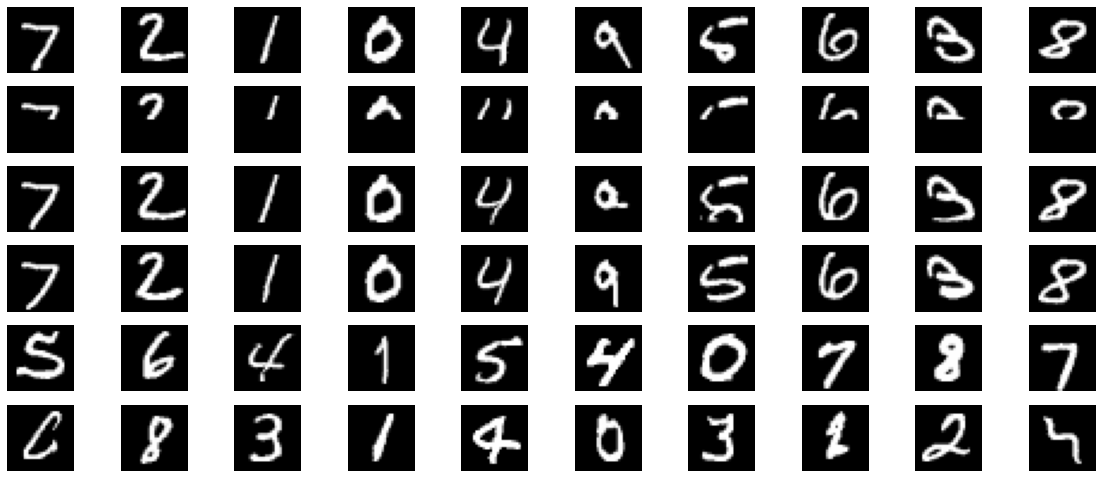

<Figure size 432x288 with 0 Axes>

In [13]:
visualize_samples(samples + masked, generated)